- GAN
  - 생성자, 판별자의 싸움
  - 생성자 : 랜덤한 잡음을 원래 데이터에서 샘플링한 것처럼 보이는 샘플을 만든다

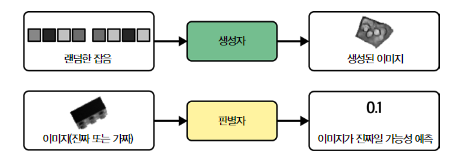

In [1]:
# 데이터 링크공유
# https://drive.google.com/drive/folders/12lUhSGWBwYrxWFGW_Ql5rTk5uDtWfao4?usp=sharing
# 원본 https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images

In [2]:
# 각자 자신의 환경에 맞게 수정
!unzip '/content/drive/MyDrive/lego_block_data/archive.zip' -d lego

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: lego/dataset/43857 beam 1x2 300R.png  
  inflating: lego/dataset/43857 beam 1x2 301L.png  
  inflating: lego/dataset/43857 beam 1x2 301R.png  
  inflating: lego/dataset/43857 beam 1x2 302L.png  
  inflating: lego/dataset/43857 beam 1x2 302R.png  
  inflating: lego/dataset/43857 beam 1x2 303L.png  
  inflating: lego/dataset/43857 beam 1x2 303R.png  
  inflating: lego/dataset/43857 beam 1x2 304L.png  
  inflating: lego/dataset/43857 beam 1x2 304R.png  
  inflating: lego/dataset/43857 beam 1x2 305L.png  
  inflating: lego/dataset/43857 beam 1x2 305R.png  
  inflating: lego/dataset/43857 beam 1x2 306L.png  
  inflating: lego/dataset/43857 beam 1x2 306R.png  
  inflating: lego/dataset/43857 beam 1x2 307L.png  
  inflating: lego/dataset/43857 beam 1x2 307R.png  
  inflating: lego/dataset/43857 beam 1x2 308L.png  
  inflating: lego/dataset/43857 beam 1x2 308R.png  
  inflating: lego/dataset/43857 beam 1x2 309L.png  
  inflating: lego/dataset/43

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from utils import display, sample_batch

In [4]:
# utils.py가 필요 (display할때)

In [5]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100 # 훈련이 오래 걸려 에포크 횟수를 300에서 100으로 줄입니다.
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [6]:
# 텐서플로 데이터 셋 만들기
from glob import glob
temp =  glob('/content/lego/dataset/*');
[paths for paths in temp if paths.split('.')[-1] !='png']

[]

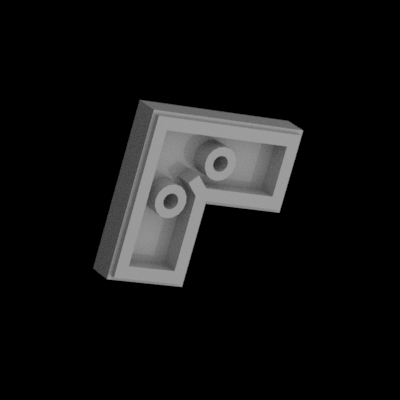

In [7]:
from PIL import Image
Image.open(temp[-1])

In [8]:
train_data = utils.image_dataset_from_directory(
    '/content/lego/dataset/',
    labels = None,
    image_size=(64,64),
    batch_size=128,
    shuffle = True,
    seed=42,
    color_mode='grayscale'
)

Found 40000 files belonging to 1 classes.


In [9]:
# 데이터 전처리
# 원본데이터 : 0 ~ 255
# GAN을 훈련할때는 데이터 -1 ~ 1 범위로 스케일 --> 마지막층 시그모이드
# 대신에 더 강한 그레이디언트 tanh를 사용하기 위해서
def preprocess(img):
  img = (tf.cast(img,'float32')-127.5 / 127.5)
  return img

train = train_data.map(lambda x : preprocess(x))

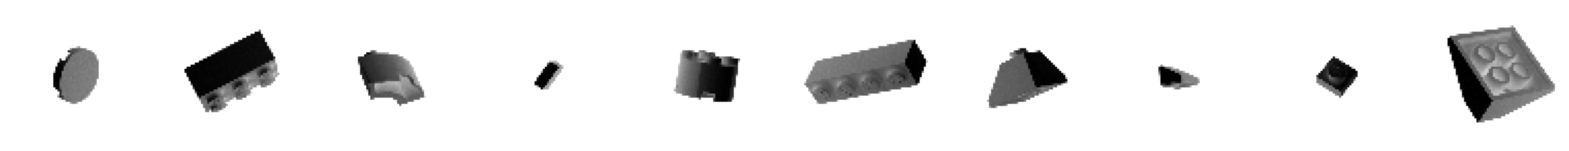

In [10]:
# 이지미 시각화
train_sample = sample_batch(train)
display(train_sample)

In [11]:
# 판별자  생성
# inputlayer - conv2d - leakyrelu -dropuout

# conv2d - batchnormal- leakyrelu -dropuout
# conv2d - batchnormal- leakyrelu -dropuout
# conv2d - batchnormal- leakyrelu -dropuout

# conv2d - flattern

In [12]:
discriminator_input = layers.Input(shape=(64,64,1))
# 바이어스 false로 하면 학습파라메터가 감소, 계산효율성증가, 특정 데이터나 문제에 따라서 성능이 향상
x = layers.Conv2D(64,kernel_size=4,strides=2,padding='same',use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False, activation='sigmoid')(x)
discriminator_output = layers.Flatten()(x)
discriminator = models.Model(discriminator_input,discriminator_output)  # Dense층을 사용하지 않는 이유는 (None, 1, 1, 1)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

In [13]:
# 생성자의 입력은 VAE와 동일한 목적으로
# 생성자
generator_input = layers.Input(shape=(100,))  # input층은 길이가 100인 벡터
x = layers.Reshape( (1,1,100))(generator_input)
x = layers.Conv2DTranspose(512,kernel_size=4,strides=1, padding='valid', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256,kernel_size=4,strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128,kernel_size=4,strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64,kernel_size=4,strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

generator_output = layers.Conv2DTranspose(1,kernel_size=4,strides=2, padding='same', use_bias=False, activation='tanh')(x)
generator = models.Model(generator_input,generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

In [14]:
# 훈련세트의 진짜 샘플과 생성자의 출력을 합쳐서 훈련세트를 만들어서 판별자를 훈련 - 지도학습
# 진짜는 레이블 1, 가짜는 레이블 0, 바이너리 크로스 엔트로피

# 생성자훈련 : 생성된 이미지에 점수를 부여하고 높은 점수를 낸 이미지로 최적화하는 방법 --> 판별자
# 판별자가 진짜라고 생각하는 이미지를 생성하도록 생성자를 훈련

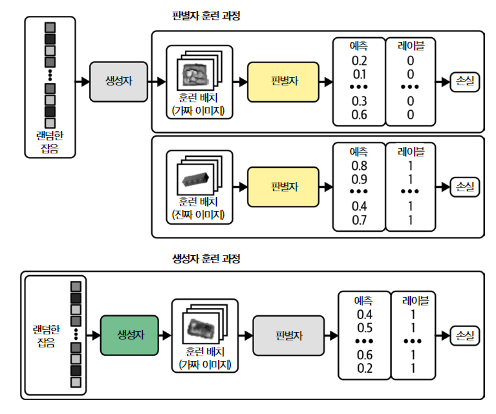

In [15]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy() # 생성자와 판별자의 손실함수는 이진 크로스 엔트로피
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # 잠재 공간에서 랜덤 포인트 샘플링
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )  # 다변량 표준 정규분포에서 배치 벡터를 샘플링

        # 가짜 이미지로 판별자 훈련하기
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )# 생성자에 전달해서 이미지 배치를 생성

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # 메트릭 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [16]:
# 모델 생성
dcgan = DCGAN(discriminator,generator,latent_dim=Z_DIM)

In [17]:
dcgan.compile(
    d_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1,beta_2 = ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1,beta_2 = ADAM_BETA_2),
)

In [18]:
# 모델 저장 체크포인트
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/lego_block_data/checkpoint.ckpt',
    save_weights_only=True,
    save_freq = 'epoch',
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 3 == 0: # 출력 횟수를 줄이기 위해
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="/content/drive/MyDrive/lego_block_data/generated_img_%03d.png" % (epoch),
            )

Epoch 1/10
313/313 [==============================] - ETA: 0s - d_loss: -0.6547 - d_real_acc: 0.9925 - d_fake_acc: 0.9925 - d_acc: 0.9925 - g_loss: 13.7874 - g_acc: 0.0075
Saved to /content/drive/MyDrive/lego_block_data/generated_img_000.png


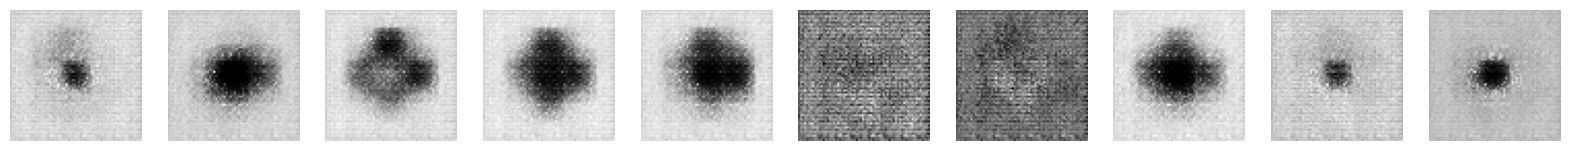

313/313 [==============================] - 97s 253ms/step - d_loss: -0.6547 - d_real_acc: 0.9925 - d_fake_acc: 0.9925 - d_acc: 0.9925 - g_loss: 13.7874 - g_acc: 0.0075
Epoch 2/10
313/313 [==============================] - 79s 247ms/step - d_loss: -0.7663 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4125 - g_acc: 0.0000e+00
Epoch 3/10
313/313 [==============================] - 78s 244ms/step - d_loss: -0.7675 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4224 - g_acc: 0.0000e+00
Epoch 4/10
313/313 [==============================] - ETA: 0s - d_loss: -0.7672 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4236 - g_acc: 0.0000e+00
Saved to /content/drive/MyDrive/lego_block_data/generated_img_003.png


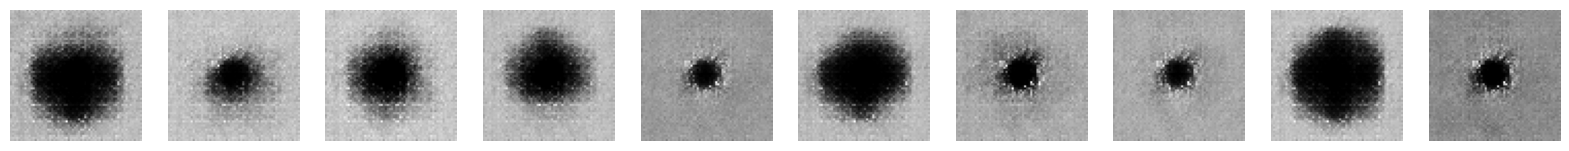

313/313 [==============================] - 79s 247ms/step - d_loss: -0.7672 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4236 - g_acc: 0.0000e+00
Epoch 5/10
313/313 [==============================] - 81s 249ms/step - d_loss: -0.7660 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4244 - g_acc: 0.0000e+00
Epoch 6/10
313/313 [==============================] - 80s 250ms/step - d_loss: -0.7669 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4243 - g_acc: 0.0000e+00
Epoch 7/10
313/313 [==============================] - ETA: 0s - d_loss: -0.7666 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4247 - g_acc: 0.0000e+00
Saved to /content/drive/MyDrive/lego_block_data/generated_img_006.png


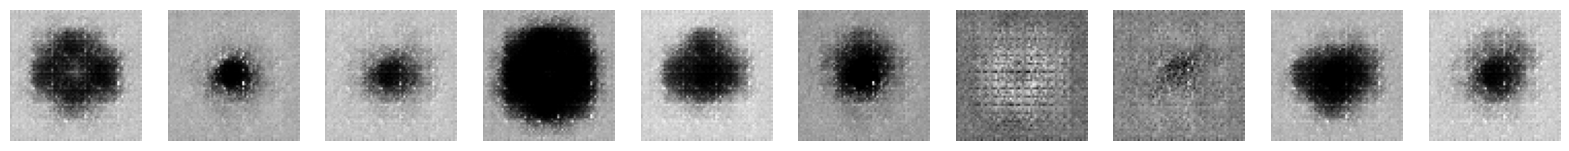

313/313 [==============================] - 79s 247ms/step - d_loss: -0.7666 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4247 - g_acc: 0.0000e+00
Epoch 8/10
313/313 [==============================] - 79s 247ms/step - d_loss: -0.7676 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4246 - g_acc: 0.0000e+00
Epoch 9/10
313/313 [==============================] - 80s 247ms/step - d_loss: -0.7643 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4247 - g_acc: 0.0000e+00
Epoch 10/10
313/313 [==============================] - ETA: 0s - d_loss: -0.7652 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00
Saved to /content/drive/MyDrive/lego_block_data/generated_img_009.png


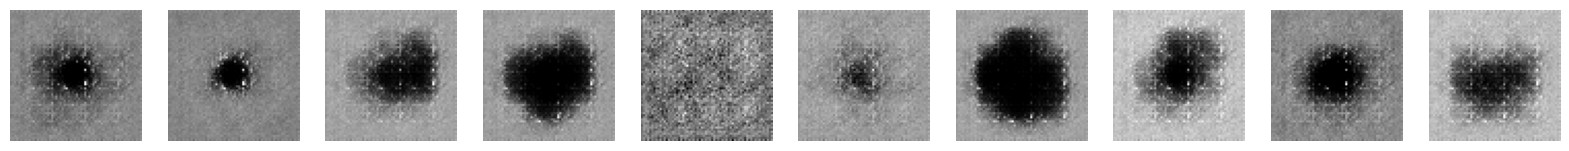

313/313 [==============================] - 80s 252ms/step - d_loss: -0.7652 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00


In [19]:
dcgan.fit(
    train,
    # epochs = EPOCHS,
    epochs = 10,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10,latent_dim=Z_DIM)
    ]
)

In [20]:
# 모델저장
generator.save('/content/drive/MyDrive/lego_block_data/model/generator')
discriminator.save('/content/drive/MyDrive/lego_block_data/model/discriminator')


In [21]:
# 새로운 이미지 생성 : 표준정규분포에서 잠재 공간의 일부 포인트를 샘플링
grid_width,grid_height = (10,3)
z_sample =  np.random.normal(size=(grid_width*grid_height,Z_DIM))

In [22]:
# 샘플링 된 포인트를 디코딩
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 417ms/step


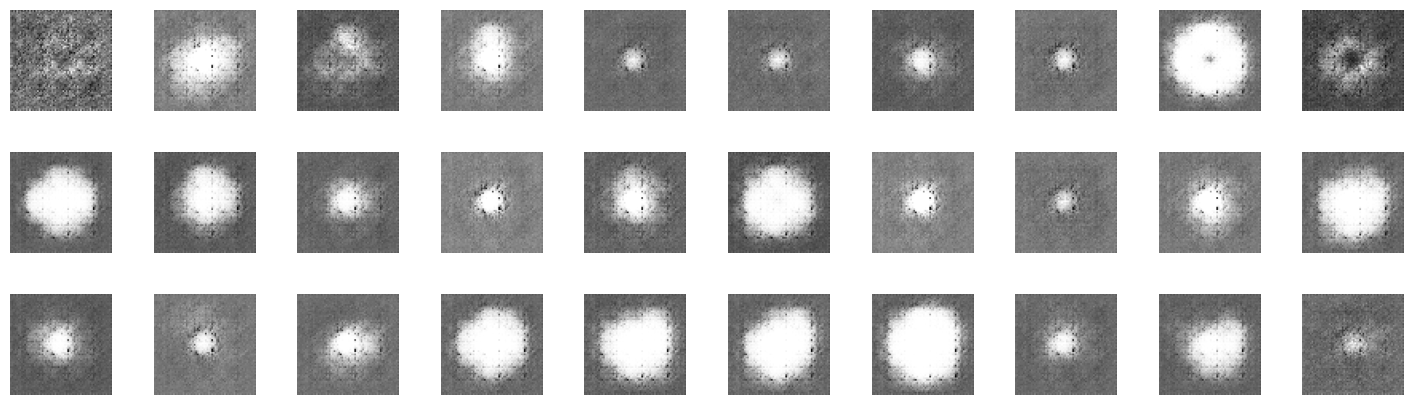

In [24]:
# 디코딩된 이미지 그리기
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis("off")
  ax.imshow(reconstructions[i, : , : ], cmap='gray')

In [25]:
# 문제점
# 판별자가 생성자 보다 훨씬 뛰어난 경우
# 판별자가 너무 강하면 손실함수의 신호가 너무 약해져서 생성자의 의미 있는 향상을 기대하기 어렵다.
# 그레이디언트가 사라져서 학습이 전혀 이루어지지 않을수 있다

# 판별자에 있는 Droupout층의 rate 매개변수 값을 증가 네트웍에 흐르는 정보의 양을 줄여준다
# 판별자의 학습을 줄인다
# 판별자의 합성곱 필터수를 줄인다
# 판별자를 훈련할때 레이블에 잡음을 추가
# 판별자를 훈련할때 일부 이미지의 레이블을 무작위로 뒤집는다

In [ ]:
# 생성자가 판별자보다 훨씬 뛰어난 경우
# 모드붕괴 mode collapse
# 판별자의 가중치를 업데이트하지 않고 몇번의 배치를 하는 동안 생성자를 훈련한다고 가정하면
# 생성자가 샘플... 판별자를 항상속이는 샘플(모드 model)
# 잠재공간에 있는 모든 포인트를 매핑못하고 손실함수의 그레이디언트가 0에 가깝게 붕괴